# Computer Vision Training YM

## 1: Introduction to Convnets with pytorch 
In this section will will build a simple convolutional model and train it to classify images from the CIFAR-10 dataset.

#### Download the data using the torchvision library

In [16]:
# convnet classification task on 
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.ToTensor()
])

cifar10_train_dataset = torchvision.datasetsw.CIFAR10("./cifar10", download=True, transform=transform, train=True)
cifar10_test_dataset = torchvision.datasets.CIFAR10("./cifar10", download=True, transform=transform, train=True)

Files already downloaded and verified
Files already downloaded and verified


#### make dataloaders from the datasets
Wrap the dataset classes in a pytorch dataloader class. This will allow us to feed the data to the model in a easy and controllable way.

target label    : ship
shape of tensors: batch=torch.Size([256, 3, 32, 32]), target=torch.Size([256])


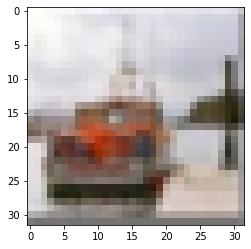

In [50]:
# adjust batch size to fit gpu space AND for finetuning the training process.
# batch size is not an insignificant factor in the training of convnets (or any neural networks for that matter)
batch_size = 256

train_loader = torch.utils.data.DataLoader(cifar10_train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=5)

test_loader = torch.utils.data.DataLoader(cifar10_test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=5)

# the dataset class should contain the mapping of label to label_idx
label_to_classname = {v: k for k, v in cifar10_test_dataset.class_to_idx.items()}

# show single sample
for batch, target in test_loader:
    sample = batch[0].permute(1, 2, 0)
    t_label = target[0].item()
    print(f"target label    : {label_to_classname[t_label]}")
    print(f"shape of tensors: batch={batch.shape}, target={target.shape}")
    plt.imshow(sample.numpy())
    break

In [135]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)
    

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.out = nn.Linear(2048, 10)  # 512 * 4 * 4

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x5 = torch.flatten(x5, 1)
        logits = self.out(x5)
        return logits
    

class VerySimpleNet(nn.Module):
    def __init__(self, n_classes):
        super(VerySimpleNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(128, 256, 3, 1)
        self.relu4 = nn.ReLU()
        self.conv5 = nn.Conv2d(256, 512, 3, 1)
        self.relu5 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.25)
        self.fc = nn.Linear(247808, n_classes)

    def forward(self, x):
        #print(x.shape)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.conv5(x)
        x = self.relu5(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [137]:
def train(model, device, train_loader, optimizer, criterion, epoch, log_interval=5, dry_run=False):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if dry_run:
                break


def test(model, device, criterion, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss
            # test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    

device = "cuda:0"
lr = 0.01
gamma = 0.7
epochs = 100
model = VerySimpleNet(10).to(device)
# model = UNet(3,10).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss().to(device)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, criterion, epoch, log_interval=10)
    test(model, device, criterion, test_loader)
    scheduler.step()


Train Epoch: 1 [0/50000 (0%)]	Loss: 2.302588
Train Epoch: 1 [2560/50000 (5%)]	Loss: 2.214403
Train Epoch: 1 [5120/50000 (10%)]	Loss: 2.084307
Train Epoch: 1 [7680/50000 (15%)]	Loss: 2.036350
Train Epoch: 1 [10240/50000 (20%)]	Loss: 1.973930
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.863580
Train Epoch: 1 [15360/50000 (31%)]	Loss: 1.820063
Train Epoch: 1 [17920/50000 (36%)]	Loss: 1.818110
Train Epoch: 1 [20480/50000 (41%)]	Loss: 1.772925
Train Epoch: 1 [23040/50000 (46%)]	Loss: 1.714329
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.800814
Train Epoch: 1 [28160/50000 (56%)]	Loss: 1.701640
Train Epoch: 1 [30720/50000 (61%)]	Loss: 1.648644
Train Epoch: 1 [33280/50000 (66%)]	Loss: 1.604365
Train Epoch: 1 [35840/50000 (71%)]	Loss: 1.516292
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.410293
Train Epoch: 1 [40960/50000 (82%)]	Loss: 1.504500
Train Epoch: 1 [43520/50000 (87%)]	Loss: 1.432383
Train Epoch: 1 [46080/50000 (92%)]	Loss: 1.488869
Train Epoch: 1 [48640/50000 (97%)]	Loss: 1.503304

Test set

KeyboardInterrupt: 

In [ ]:
# Lets look at some classification examples from the test set, how is the performance of the model?

target label: dog, predicted label: automobile


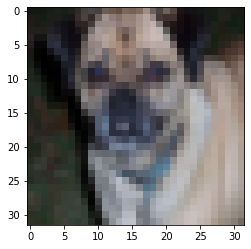

In [62]:
import matplotlib.pyplot as plt

for batch, target in test_loader:
    sample = batch[0].permute(1, 2, 0)
    output = model(batch.to(device))
    p_label = torch.argmax(output[0]).item()
    t_label = target[0].item()
    print(f"target label: {label_to_classname[t_label]}, predicted label: {label_to_classname[p_label]}")
    plt.imshow(sample.numpy())
    
    break

## Understanding Convnets - Architecture, Backbones & Layers
Backbones are large (often pretrained) neural networks that serve as a way to extract features that are useful for almost all types of problems.
The general idea of a backbone is to have a model that is very good at identifying high level features in an image. 
The easiest way to understand this is to think of images as collections of shapes. A face is just a collection of circles (such as the eyes) and curvy lines.
This means that if we already have a model that can detect all these components the step to the full combination of those components (such as a face) is a lot easier!
In practice most pretrained backbones will already have concepts such as faces embedded into the layers. Additionally, lines and circles are actually pretty basic features and a large pretrained backbone will contain much more complex concepts.

### Revisiting CIFAR-10 
Now we know about backbones, let's use one on the CIFAR-10 dataset. For this we'll need to download a pretrained model and adjust the number of classes

In [153]:
import torchvision.models as models

resnext50 = models.resnext50_32x4d(pretrained=True)
# model = models.resnext50_32x4d(pretrained=False)

# you can always print a model to see the full structure or even the partial structure if you select it.
print(resnext50.layer1)

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2)

#### Changing a backbone
We now want to change the backbone so it fits our 10 class classification problem. There are a few ways to do this and here we will look at both of the methods.

1. The first (and easiest) way is to change the model is to just swap out the last layer. In this case the original model was already a classification model and we are just changing the number of output classes in the last layer to fit our problem. In this case this is also the most 'correct' way of doing it.
2. The second way to adjust the model is to wrap it in a new model class. This method is useful in more complicated scenarios where you want to change more than just the number of outputs. For example if we wanted to use the backbone as the basis for a segmentation model. Now before you ask, yes wrapping the backbone like this preserves the last layer that would be replaced in the other example, luckily this does not effect performance (only memory usage).

In [150]:
resnext50 = models.resnext50_32x4d(pretrained=True)
num_classes = 10

# change the last layer of the model, (run the training cell further below to see if it worked):
resnext50.fc = nn.Linear(2048, num_classes)

print(resnext50)

In [158]:
# now let's wrap our model in a pytorch module instead, this is syntactically the same as adding a layer to a regular network.

class WrappedResnext(nn.Module):
    def __init__(self, n_classes, backbone):
        super(WrappedResnext, self).__init__()
        self.backbone = backbone
        self.fc2 = nn.Linear(1000, n_classes)

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc2(x)
        return x

resnext50 = models.resnext50_32x4d(pretrained=True)
model = WrappedResnext(10, resnext50)
print(model)

WrappedResnext(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample

#### Test your adjusted model by running this cell

In [159]:
model = model.to(device)
epochs = 10
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to(device)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, criterion, epoch, log_interval=10)
    test(model, device, criterion, test_loader)
    scheduler.step()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.906863
Train Epoch: 1 [2560/50000 (5%)]	Loss: 1.859856
Train Epoch: 1 [5120/50000 (10%)]	Loss: 1.656146
Train Epoch: 1 [7680/50000 (15%)]	Loss: 1.412381
Train Epoch: 1 [10240/50000 (20%)]	Loss: 1.368838
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.294761
Train Epoch: 1 [15360/50000 (31%)]	Loss: 1.061087
Train Epoch: 1 [17920/50000 (36%)]	Loss: 1.143962
Train Epoch: 1 [20480/50000 (41%)]	Loss: 1.074286
Train Epoch: 1 [23040/50000 (46%)]	Loss: 1.228976
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.086726
Train Epoch: 1 [28160/50000 (56%)]	Loss: 0.778796
Train Epoch: 1 [30720/50000 (61%)]	Loss: 0.914323
Train Epoch: 1 [33280/50000 (66%)]	Loss: 0.923098
Train Epoch: 1 [35840/50000 (71%)]	Loss: 0.758366
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.766399
Train Epoch: 1 [40960/50000 (82%)]	Loss: 0.771607
Train Epoch: 1 [43520/50000 (87%)]	Loss: 0.874980
Train Epoch: 1 [46080/50000 (92%)]	Loss: 0.684470
Train Epoch: 1 [48640/50000 (97%)]	Loss: 0.543703

Test set

KeyboardInterrupt: 

## Understanding Convnets - Model architecture
In this section we'll look at Unet, a (compared to more recent models) classic deep learning segmentation model that introduced the concept of encoder-decoder architecture for convnets. It is also fairly easy to understand. It consists of two parts, the encoder and the decoder. The Encoder has the same job as the backbone has in the previous section. Its purpose is to extract features from the image, that will then be used in the later half of the model to make the segmentation. In this analogy the Decoder does the same thing as the single layer of linear nodes in the backbone example. It uses the features supplied by the encoder to make the full image segmentation. 

Now that we have a general idea, what are the other interesting parts of the model? 
1. As we can see in the image, the shape of the layers gets deeper in filters but smaller in width/height.
This is done to allow the model to learn larger more complex concepts. As the size of the convolutional filters stays the same throughout the model (generally kernel size is always 3x3), a larger object like a car would never fit in those 3 pixels. By downsizing the output after each layer, a full object CAN be represented in that 3x3 grid of pictures. This is because filters specialize, a certain filter in the 4th layer of the model might only respond to a specific pattern that was found in the previous layer. That pattern is again already an abstraction upon the previous input.

2. What are those grey lines jumping from the enconder part to the decoder part? As you might have suspected this is just the output of that layer being saved and copied to be concatenated to the decoder at the mirrored layer later. This is done because a lot of spatial detail is lost in the process of downsampling. By adding the higher resolution data from the downsampling process this effect is somewhat mitigated as the network is able to use this data to make more precise object boundries. 

![alt text](https://miro.medium.com/max/2824/1*f7YOaE4TWubwaFF7Z1fzNw.png "Logo Title Text 1")


#### Building the segmentation model
Fill in the empty functions and complete the model.

In [ ]:
## From classification model to segmentation model

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   

class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        x = self.dconv_down4(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       
        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        x = self.dconv_up1(x)
        out = self.conv_last(x)
        return out

#### Testing the model 
Lets now try out our new model on another pytorch/torchvision dataset. We'll use the 

In [182]:
import matplotlib.pyplot as plt

test_loader = torch.utils.data.DataLoader(sbd_dataset,
                                          batch_size=4,
                                          shuffle=True,
                                          num_workers=5)

for thing in test_loader:
    print(thing)
#     sample = batch[0].permute(1, 2, 0)
#     output = model(batch.to(device))
#     p_label = torch.argmax(output[0]).item()
#     t_label = target[0].item()
#     print(f"target label: {label_to_classname[t_label]}, predicted label: {label_to_classname[p_label]}")
#     plt.imshow(sample.numpy())
    
    break

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/parting/anaconda3/envs/pytorch16/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 185, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/parting/anaconda3/envs/pytorch16/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "/home/parting/anaconda3/envs/pytorch16/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 84, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/home/parting/anaconda3/envs/pytorch16/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 84, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/home/parting/anaconda3/envs/pytorch16/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 86, in default_collate
    raise TypeError(default_collate_err_msg_format.format(elem_type))
TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>


In [184]:
for thing in test_loader:
    print(thing)

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/parting/anaconda3/envs/pytorch16/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 185, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/parting/anaconda3/envs/pytorch16/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "/home/parting/anaconda3/envs/pytorch16/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 84, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/home/parting/anaconda3/envs/pytorch16/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 84, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/home/parting/anaconda3/envs/pytorch16/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 86, in default_collate
    raise TypeError(default_collate_err_msg_format.format(elem_type))
TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>


In [181]:
# this dataset is 1.4 Gigabyte so be patient. 
from torchvision import transforms

transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.ToTensor()
])

sbd_dataset = torchvision.datasets.SBDataset(root="./sbd", download=True, mode="segmentation", image_set='train', transforms=transform)

Using downloaded and verified file: ./sbd/benchmark.tgz


Error: Destination path './sbd/cls' already exists

# Understanding Convnets - Filter Visualization 

In [170]:
dir(torchvision.datasets)

['CIFAR10',
 'CIFAR100',
 'Caltech101',
 'Caltech256',
 'CelebA',
 'Cityscapes',
 'CocoCaptions',
 'CocoDetection',
 'DatasetFolder',
 'EMNIST',
 'FakeData',
 'FashionMNIST',
 'Flickr30k',
 'Flickr8k',
 'HMDB51',
 'ImageFolder',
 'ImageNet',
 'KMNIST',
 'Kinetics400',
 'LSUN',
 'LSUNClass',
 'MNIST',
 'Omniglot',
 'PhotoTour',
 'QMNIST',
 'SBDataset',
 'SBU',
 'SEMEION',
 'STL10',
 'SVHN',
 'UCF101',
 'USPS',
 'VOCDetection',
 'VOCSegmentation',
 'VisionDataset',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'caltech',
 'celeba',
 'cifar',
 'cityscapes',
 'coco',
 'fakedata',
 'flickr',
 'folder',
 'hmdb51',
 'imagenet',
 'kinetics',
 'lsun',
 'mnist',
 'omniglot',
 'phototour',
 'sbd',
 'sbu',
 'semeion',
 'stl10',
 'svhn',
 'ucf101',
 'usps',
 'utils',
 'video_utils',
 'vision',
 'voc']

# Convnets for spatially related non-image data

http://machine-listening.eecs.qmul.ac.uk/bird-audio-detection-challenge/#downloads